In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from tqdm import tqdm

In [48]:
x = pd.read_excel('data/Preprocessed_AFData.xlsx')

In [3]:
x

,data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,...,data22,data23,data24,data25,data26,data27,data28,data29,data30,Control
0,0.0,0.0,0.0,0.1,-0.1,0.000000,0.000000,0.400000,0.100000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,1.000000,-0.400000,-0.600000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.954545,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0.0,0.0,0.0,0.5,0.5,-0.071429,-0.214286,-0.357143,-0.214286,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
149996,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
149997,0.0,0.0,0.3,0.7,-0.8,0.200000,-0.050000,-0.050000,-0.150000,-0.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
149998,0.0,0.0,0.0,0.0,0.0,0.050000,0.000000,-0.050000,0.050000,-0.050000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


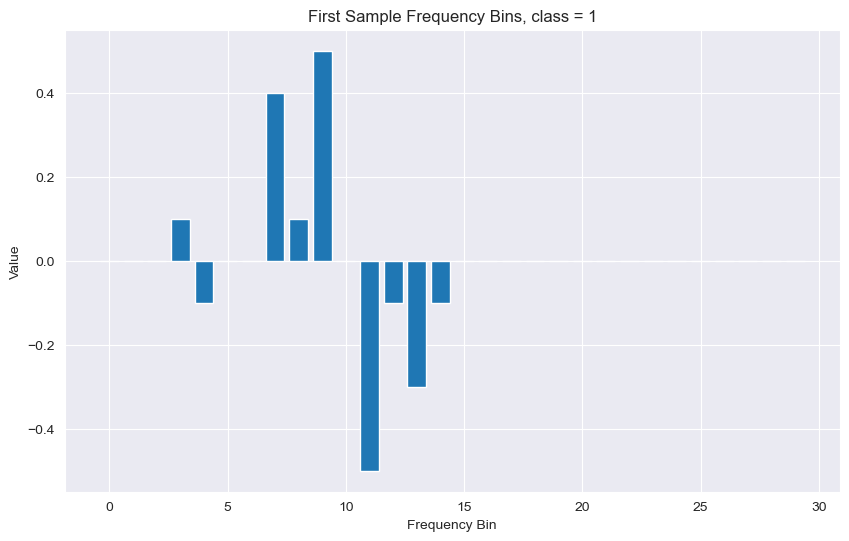

In [4]:
s_n = 0
sample = x.iloc[s_n, :-1]
sample_gt = x.iloc[s_n, -1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sample)), sample)
plt.xlabel('Frequency Bin')
plt.ylabel('Value')
plt.title(f'First Sample Frequency Bins, class = {sample_gt}')
plt.show()

In [53]:
def get_nearest_neighbour_distance(tree, point, points, exclude_point):
    dist, idx = tree.query(point)
    if np.array_equal(points[idx], exclude_point):
        # Find the second nearest neighbor if the nearest neighbor is the point itself
        dist, idx = tree.query(point, k=2)
        dist = dist[1]  # Take the second nearest neighbor distance
    return dist

def get_N2(x):
    # Prepare KD-trees for both classes
    class_0_points = x[x['Control'] == 0].iloc[:, :-1].values
    class_1_points = x[x['Control'] == 1].iloc[:, :-1].values
    
    tree_class_0 = KDTree(class_0_points)
    tree_class_1 = KDTree(class_1_points)
    
    # N2 = \sum \delta(point, nearest neighbour of the same class) / \sum \delta(point, nearest neighbour of the different class)
    sum_same = 0
    sum_diff = 0
    
    for i in tqdm(range(len(x)), desc="Calculating N2"):
        point = x.iloc[i, :-1].values
        gt = x.iloc[i, -1]
    
        if gt == 0:
            sum_same += get_nearest_neighbour_distance(tree_class_0, point, class_0_points, point)
            sum_diff += get_nearest_neighbour_distance(tree_class_1, point, class_1_points, point)
        else:
            sum_same += get_nearest_neighbour_distance(tree_class_1, point, class_1_points, point)
            sum_diff += get_nearest_neighbour_distance(tree_class_0, point, class_0_points, point)
    
    N2 = sum_same / sum_diff
    
    return N2


In [ ]:
N2_before = get_N2(x)

In [62]:
n_class_0 = x['Control'].value_counts()[0]
n_class_1 = x['Control'].value_counts()[1]

# Print the number of samples in each class
print(f'Class 0 count: {n_class_0}') # = 113463
print(f'Class 1 count: {n_class_1}') # = 36537

# Balance the dataset by reducing the majority class size to be equal to the minority class size
x_balanced = pd.concat([x[x['Control'] == 0].sample(n=n_class_1, random_state=42), x[x['Control'] == 1]])
x_balanced['Control'].value_counts()

Class 0 count: 113463
Class 1 count: 36537


Control
0    36537
1    36537
Name: count, dtype: int64

In [54]:
N2_after = get_N2(x_balanced)
print(f'N2 before balancing: {N2_before}')
print(f'N2 after balancing: {N2_after}')

Calculating N2: 100%|██████████| 73074/73074 [00:35<00:00, 2084.80it/s]

N2 before balancing: 0.38127059081207876
N2 after balancing: 0.4915929956122295


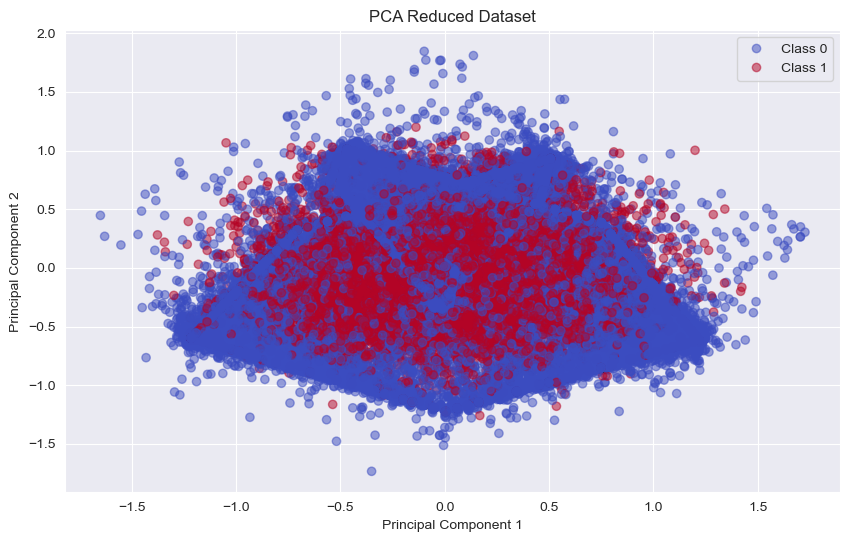

Calculating N2: 100%|██████████| 150000/150000 [00:18<00:00, 8074.03it/s]


In [58]:
# Apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset to 2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_balanced.iloc[:, :-1])
x_pca = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
# add the class labels as a column to the dataframe
x_pca = pd.concat([x_pca, x['Control']], axis=1)

# Plot the PCA reduced dataset
plt.figure(figsize=(10, 6))

scatter = plt.scatter(x_pca['PC1'], x_pca['PC2'], c=x_pca['Control'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduced Dataset')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.show()

# calculatae N2 for the PCA reduced dataset
N2_pca = get_N2(x_pca)
print(f'N2: {N2_pca}')

In [95]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample the data
data_tsne = x_balanced.sample(n=10000, random_state=42)

# Print value counts of the Control column
print(data_tsne['Control'].value_counts())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=2000)
x_tsne = tsne.fit_transform(data_tsne.iloc[:, :-1])
x_tsne = pd.DataFrame(x_tsne, columns=['t-SNE1', 't-SNE2'])

# Add the class labels as a column to the DataFrame
x_tsne['Control'] = data_tsne['Control'].values


Control
0    5031
1    4969
Name: count, dtype: int64


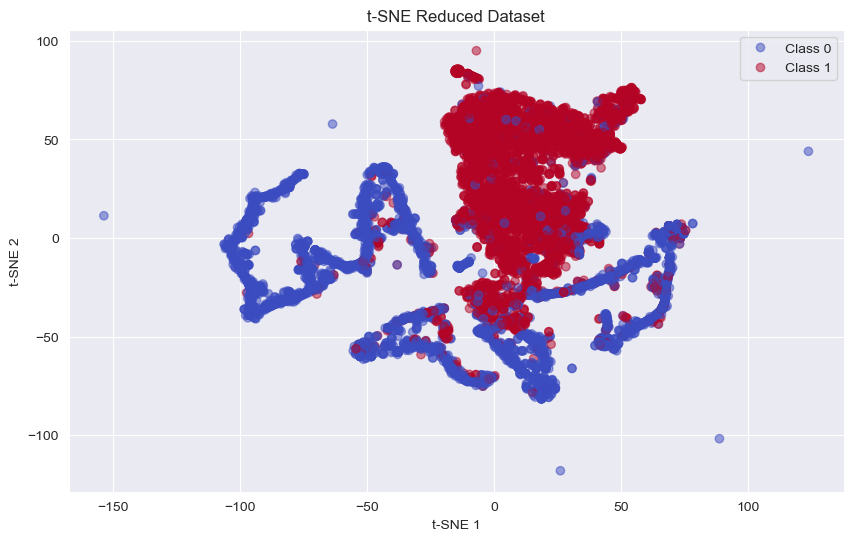

Text(0, 0.5, 't-SNE 2')

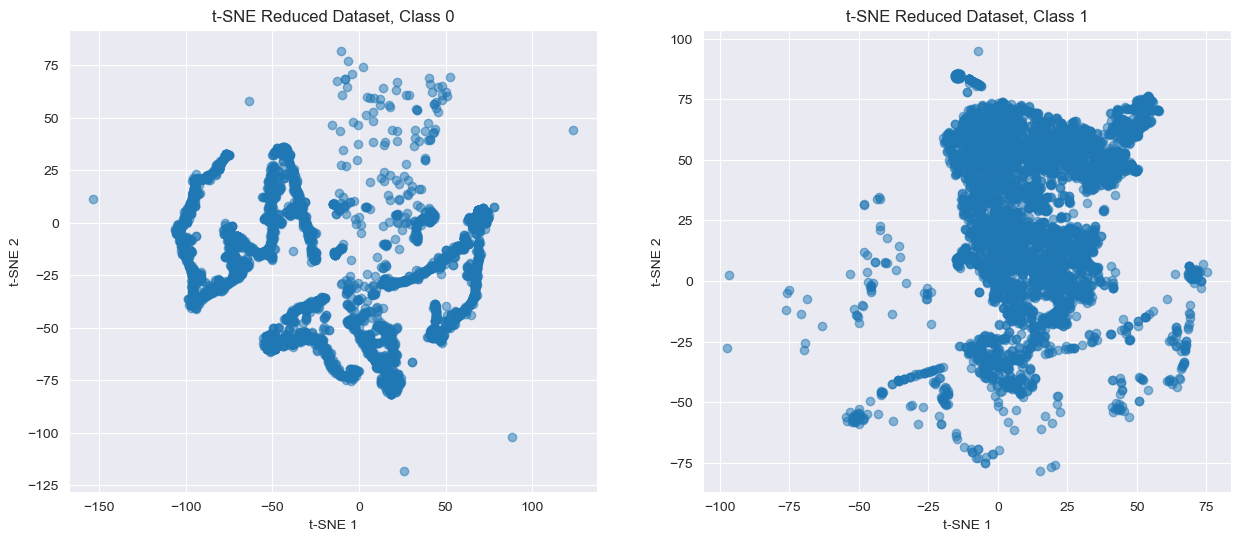

In [96]:
# Plot the t-SNE reduced dataset
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_tsne['t-SNE1'], x_tsne['t-SNE2'], c=x_tsne['Control'], cmap='coolwarm', alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Reduced Dataset')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.show()

# make a figure with two subplots, one for each class
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot the t-SNE reduced dataset for class 0
scatter = ax[0].scatter(x_tsne[x_tsne['Control'] == 0]['t-SNE1'], x_tsne[x_tsne['Control'] == 0]['t-SNE2'], alpha=0.5)
ax[0].set_title('t-SNE Reduced Dataset, Class 0')
ax[0].set_xlabel('t-SNE 1')
ax[0].set_ylabel('t-SNE 2')

# Plot the t-SNE reduced dataset for class 1
scatter = ax[1].scatter(x_tsne[x_tsne['Control'] == 1]['t-SNE1'], x_tsne[x_tsne['Control'] == 1]['t-SNE2'], alpha=0.5)
ax[1].set_title('t-SNE Reduced Dataset, Class 1')
ax[1].set_xlabel('t-SNE 1')
ax[1].set_ylabel('t-SNE 2')

# Calculate N2 for the t-SNE reduced dataset
# N2_tsne = get_N2(x_tsne)
# print(f'N2: {N2_tsne}')

In [97]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = df_balanced.iloc[:, :-1].values
y = df_balanced.iloc[:, -1].values

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=1)

svm = SVC(random_state=42, kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)

print(f"Accuracy: {acc_svm}, F1: {f1_svm}")

(73074, 30) (73074,)
Accuracy: 0.9521063434659368, F1: 0.9513792419130781


In [100]:
# create z_test, which labels the test set with either 0, 1, 2 or 3, based on whether it is TP, TN, FP or FN
z_test = np.zeros(len(y_test))
z_test[(y_test == 1) & (y_pred == 1)] = 0  # True Positives
z_test[(y_test == 0) & (y_pred == 0)] = 1  # True Negatives
z_test[(y_test == 0) & (y_pred == 1)] = 2  # False Positives
z_test[(y_test == 1) & (y_pred == 0)] = 3  # False Negatives

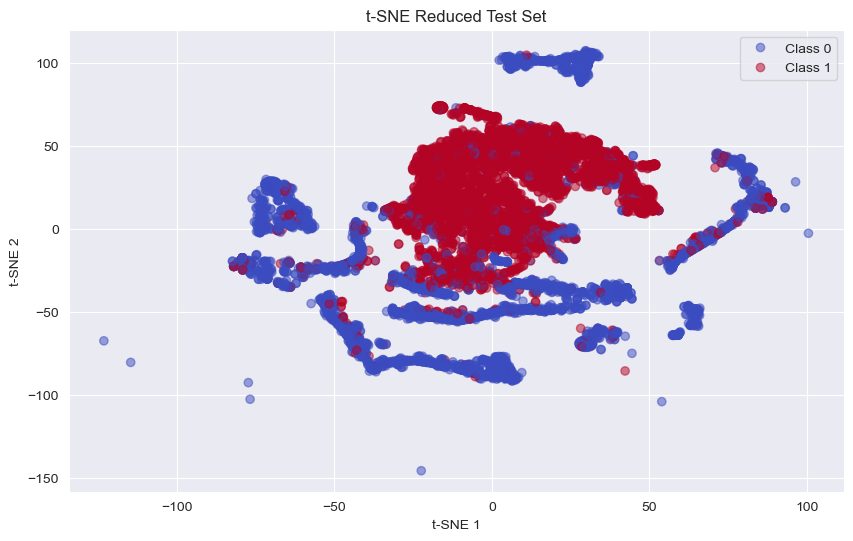

In [99]:
# apply t-SNE on the test set
x_test_tsne = tsne.fit_transform(X_test)
x_test_tsne = pd.DataFrame(x_test_tsne, columns=['t-SNE1', 't-SNE2'])
x_test_tsne['Control'] = y_test

# Plot the t-SNE reduced dataset
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_test_tsne['t-SNE1'], x_test_tsne['t-SNE2'], c=x_test_tsne['Control'], cmap='coolwarm', alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Reduced Test Set')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.show()


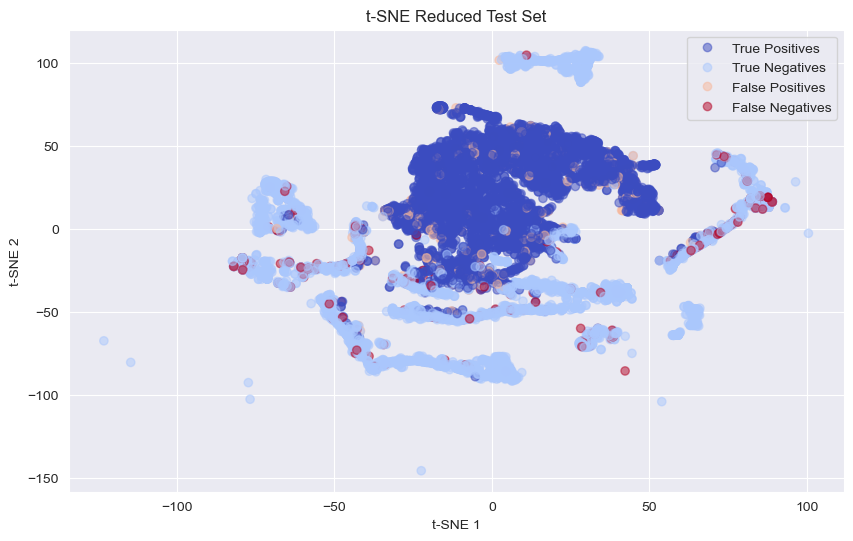

In [101]:
#plot t-SNE for the test set with the z_test labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_test_tsne['t-SNE1'], x_test_tsne['t-SNE2'], c=z_test, cmap='coolwarm', alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Reduced Test Set')
plt.legend(handles=scatter.legend_elements()[0], labels=['True Positives', 'True Negatives', 'False Positives', 'False Negatives'])
plt.show()

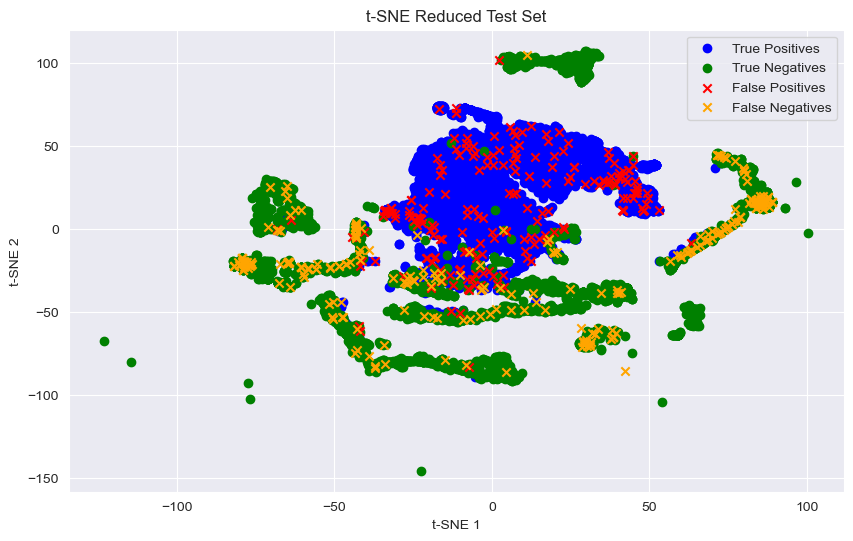

Text(0, 0.5, 't-SNE 2')

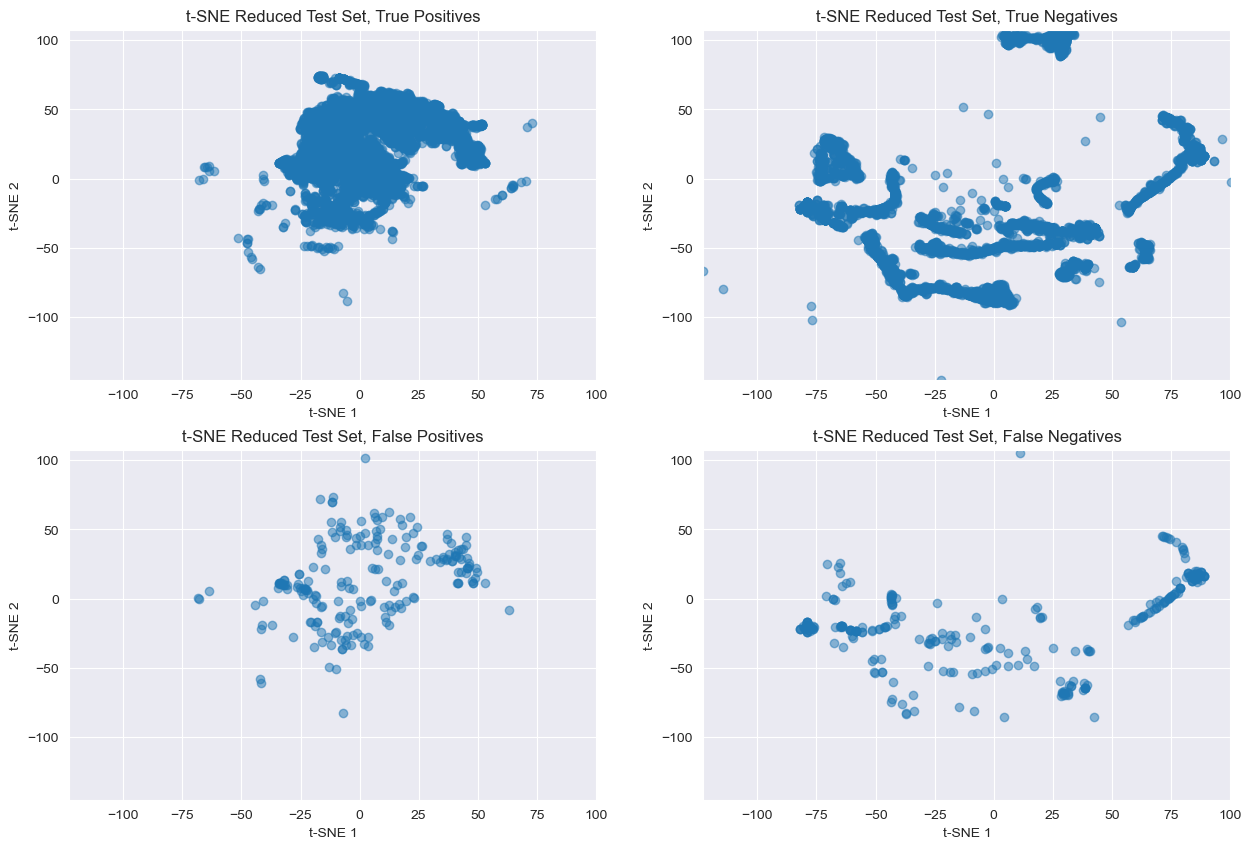

In [105]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Create a custom color map
cmap = mcolors.ListedColormap(['blue', 'green', 'red', 'orange'])

# Define the markers
markers = ['o', 'o', 'x', 'x']

# Create a scatter plot with custom color map and markers
plt.figure(figsize=(10, 6))
for idx, (marker, label) in enumerate(zip(markers, ['True Positives', 'True Negatives', 'False Positives', 'False Negatives'])):
    plt.scatter(x_test_tsne['t-SNE1'][z_test == idx], x_test_tsne['t-SNE2'][z_test == idx], c=cmap.colors[idx], marker=marker, alpha=1, label=label)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Reduced Test Set')
plt.legend()
plt.show()

# create 1 plot with 4 subplots, one for each type FN, FP, TN, TP
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

xlims = (x_test_tsne['t-SNE1'].min(), x_test_tsne['t-SNE1'].max())
ylims = (x_test_tsne['t-SNE2'].min(), x_test_tsne['t-SNE2'].max())

# Plot the t-SNE reduced dataset for True Positives
scatter = ax[0, 0].scatter(x_test_tsne[z_test == 0]['t-SNE1'], x_test_tsne[z_test == 0]['t-SNE2'], alpha=0.5)
ax[0, 0].set_xlim(xlims)
ax[0, 0].set_ylim(ylims)
ax[0, 0].set_title('t-SNE Reduced Test Set, True Positives')
ax[0, 0].set_xlabel('t-SNE 1')
ax[0, 0].set_ylabel('t-SNE 2')


# Plot the t-SNE reduced dataset for True Negatives
scatter = ax[0, 1].scatter(x_test_tsne[z_test == 1]['t-SNE1'], x_test_tsne[z_test == 1]['t-SNE2'], alpha=0.5)
ax[0, 1].set_xlim(xlims)
ax[0, 1].set_ylim(ylims)
ax[0, 1].set_title('t-SNE Reduced Test Set, True Negatives')
ax[0, 1].set_xlabel('t-SNE 1')
ax[0, 1].set_ylabel('t-SNE 2')

# Plot the t-SNE reduced dataset for False Positives
scatter = ax[1, 0].scatter(x_test_tsne[z_test == 2]['t-SNE1'], x_test_tsne[z_test == 2]['t-SNE2'], alpha=0.5)
ax[1, 0].set_xlim(xlims)
ax[1, 0].set_ylim(ylims)
ax[1, 0].set_title('t-SNE Reduced Test Set, False Positives')
ax[1, 0].set_xlabel('t-SNE 1')
ax[1, 0].set_ylabel('t-SNE 2')

# Plot the t-SNE reduced dataset for False Negatives
scatter = ax[1, 1].scatter(x_test_tsne[z_test == 3]['t-SNE1'], x_test_tsne[z_test == 3]['t-SNE2'], alpha=0.5)
ax[1, 1].set_xlim(xlims)
ax[1, 1].set_ylim(ylims)
ax[1, 1].set_title('t-SNE Reduced Test Set, False Negatives')
ax[1, 1].set_xlabel('t-SNE 1')
ax[1, 1].set_ylabel('t-SNE 2')

